In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from openparticle import ParticleOperator
import numpy as np
import cirq
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../../..'))
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../..'))
from src.lobe.asp import get_target_state, add_prepare_circuit
from src.lobe.system import System
from src.lobe.lcu import LCU
from colors import *
from src.lobe.bosonic import bosonic_product_block_encoding, bosonic_product_plus_hc_block_encoding
from src.lobe.index import index_over_terms
from src.lobe.metrics import CircuitMetrics
from src.lobe._utils import get_bosonic_exponents
from src.lobe.rescale import rescale_coefficients
from tests._utils import _validate_block_encoding
from functools import partial

/Users/williamsimon/Desktop/Research/SparseOracle/lobe/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/williamsimon/Desktop/Research/SparseOracle/lobe/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-04 18:07:26,275	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
def qosc_Hamiltonian(g):
    return ParticleOperator('a0^ a0') + g * (
        ParticleOperator('a0^') + ParticleOperator('a0')
    )**4

In [4]:
def lcu_ify(max_bosonic_occupancy):
    operator = qosc_Hamiltonian(g = 1).normal_order()
    operator.remove_identity()

    lcu = LCU(operator, max_bosonic_occupancy=max_bosonic_occupancy, zero_threshold=1e-6)
    ctrls = ([cirq.LineQubit(-1000000)], [1])
    circuit = cirq.Circuit()
    circuit += cirq.X.on(ctrls[0][0])
    circuit += lcu.get_circuit(ctrls=ctrls)
    circuit += cirq.X.on(ctrls[0][0])
    fake_sys = System(1, max_bosonic_occupancy, 1000 + lcu.number_of_index_qubits, operator.has_fermions, operator.has_antifermions, operator.has_bosons)
    _validate_block_encoding(circuit, fake_sys, lcu.one_norm, operator, len(lcu.index_register), max_bosonic_occupancy, max_qubits=16, using_pytest=False)

    return lcu.circuit_metrics, lcu.one_norm, len(lcu.index_register)

In [5]:
def lobotomize(max_bosonic_occupancy):
    operator = qosc_Hamiltonian(1).normal_order()
    operator.remove_identity()
    terms = operator.group()
    
    number_of_block_encoding_anillae = 2
    index_register = [cirq.LineQubit(-i - 2) for i in range(int(np.ceil(np.log2(len(terms)))))]
    block_encoding_ancillae = [cirq.LineQubit(-100 - i - len(index_register)) for i in range(number_of_block_encoding_anillae)]
    ctrls = ([cirq.LineQubit(0)], [1])
    clean_ancillae = [cirq.LineQubit(i + 100) for i in range(100)]
    system = System(1, max_bosonic_occupancy, 1000, False, False, True)

    block_encoding_functions = []
    rescaling_factors = []
    for term in terms:
        plus_hc = False
        if len(term) == 2:
            plus_hc = True
            term = term.to_list()[0]
        active_modes, exponents_list = get_bosonic_exponents(term, 1)
        exponents = exponents_list[0]

        if not plus_hc:
            block_encoding_functions.append(partial(
                bosonic_product_block_encoding,
                system=system,
                block_encoding_ancillae=[block_encoding_ancillae[1]],
                active_indices=[active_modes[0]],
                exponents_list=[exponents],
                clean_ancillae=clean_ancillae[1:]
            ))
            rescaling_factors.append(np.sqrt(max_bosonic_occupancy)**(sum(exponents)))
        else:
            block_encoding_functions.append(partial(
                bosonic_product_plus_hc_block_encoding,
                system=system,
                block_encoding_ancillae=block_encoding_ancillae,
                active_indices=[active_modes[0]],
                exponents_list=[exponents],
                clean_ancillae=clean_ancillae[1:]
            ))
            rescaling_factors.append(2*np.sqrt(max_bosonic_occupancy)**(sum(exponents)))


    rescaled_coefficients, overall_rescaling_factor = rescale_coefficients(
        [term.coeffs[0] for term in terms],
        rescaling_factors
    )
    target_state = get_target_state(rescaled_coefficients)
    
    # Generate Circuit
    gates = []
    metrics = CircuitMetrics()

    gates.append(cirq.X.on(ctrls[0][0]))
    _gates, _metrics = add_prepare_circuit(index_register, target_state, clean_ancillae=clean_ancillae)
    gates += _gates
    metrics += _metrics

    _gates, _metrics = index_over_terms(index_register, block_encoding_functions, clean_ancillae, ctrls=ctrls)
    gates += _gates
    metrics += _metrics

    _gates, _metrics = add_prepare_circuit(index_register, target_state, dagger=True, clean_ancillae=clean_ancillae)
    gates += _gates
    metrics += _metrics
    gates.append(cirq.X.on(ctrls[0][0]))

    circuit = cirq.Circuit(gates)
    _validate_block_encoding(circuit, system, overall_rescaling_factor, operator, len(index_register) + number_of_block_encoding_anillae, max_bosonic_occupancy, max_qubits=16, using_pytest=False)

    return  metrics, overall_rescaling_factor, len(index_register) + number_of_block_encoding_anillae

In [6]:
omegas = [1, 3, 7, 15, 31, 63, 127]

operator = qosc_Hamiltonian(1).normal_order()
operator.remove_identity()

print("LCU")
LCU_DATA = [lcu_ify(omega) for omega in omegas]
print("LOBE")
LOBE_DATA = [lobotomize(omega) for omega in omegas]

system_qubits = [System(1, omega, 1000, False, False, True).number_of_system_qubits for omega in omegas]

LCU
Testing singular quantum state for circuit with 12 qubits
Testing singular quantum state for circuit with 14 qubits
Too many qubits to validate: 17
Too many qubits to validate: 19
LOBE
Testing singular quantum state for circuit with 12 qubits
Testing singular quantum state for circuit with 14 qubits
Too many qubits to validate: 16
Too many qubits to validate: 18
Too many qubits to validate: 20
Too many qubits to validate: 22


In [7]:
def matrix_element(k, l, g):
    return (k + 3 * g * (2 * k ** 2 + 2 * k + 1)) * delta(k, l) +\
            g * (4 * l + 6) * np.sqrt((l + 1) * (l + 2)) * delta(k, l + 2) +\
            g * (4 * k + 6) * np.sqrt((k + 1) * (k + 2)) * delta(k + 2, l) +\
            g * np.sqrt((l + 1) * (l + 2) * (l + 3) * (l + 4)) * delta(k, l + 4) +\
            g * np.sqrt((k + 1) * (k + 2) * (k + 3) * (k + 4)) * delta(k + 4, l) 

def delta(k, l):
    if k == l: return 1 
    return 0

def _get_qosc_l2_norm(max_bosonic_occupancy, g=1):
    H_from_matrix_elements = np.zeros((max_bosonic_occupancy + 1, max_bosonic_occupancy + 1))

    for i in range(max_bosonic_occupancy + 1):
        for j in range(max_bosonic_occupancy + 1):
            H_from_matrix_elements[i][j] = matrix_element(i, j, g)

    id_val = qosc_Hamiltonian(g).normal_order().pop_identity()
    H_from_matrix_elements = H_from_matrix_elements - (id_val * np.eye(H_from_matrix_elements.shape[0]))
            
    return np.linalg.norm(H_from_matrix_elements, ord=2)

In [8]:
operator_norms = []
for omega in omegas:
    operator_norms.append(_get_qosc_l2_norm(omega))
    print(omega, operator_norms[-1])

1 13.0
3 83.50949253027683
7 462.3766497208945
15 2369.168169309278
31 11339.805337479918
63 51379.884091084525
127 223575.00102086287


/var/folders/1d/rzphqnd150gd17mlcd4p1whw0000gn/T/ipykernel_20838/487458643.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1][2].set_yticklabels([0, "$2e^5$", "$4e^5$"])


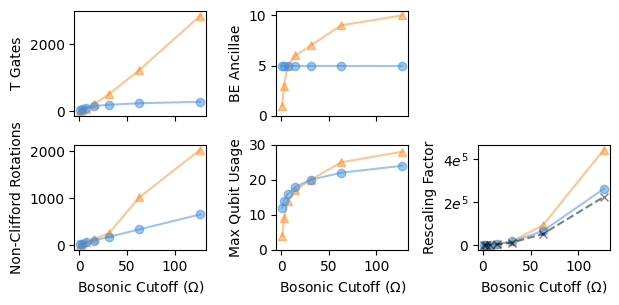

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(16 / 2.54, 8 / 2.54))

axes[0][0].plot(omegas, [4*LCU_DATA[i][0].number_of_elbows for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 0.5)
axes[0][0].plot(omegas, [4*LOBE_DATA[i][0].number_of_elbows for i in range(len(omegas))], color=BLUE, marker='o', alpha = 0.5)
axes[0][0].set_ylabel("T Gates")
axes[0][0].set_xticklabels([])

axes[1][0].plot(omegas, [LCU_DATA[i][0].number_of_nonclifford_rotations for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 0.5)
axes[1][0].plot(omegas, [LOBE_DATA[i][0].number_of_nonclifford_rotations for i in range(len(omegas))], color=BLUE, marker='o', alpha = 0.5)
axes[1][0].set_ylabel("Non-Clifford Rotations")
axes[1][0].set_xlabel("Bosonic Cutoff ($\Omega$)")

axes[0][1].plot(omegas, [LCU_DATA[i][2] for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 0.5)
axes[0][1].plot(omegas, [LOBE_DATA[i][2] for i in range(len(omegas))], color=BLUE, marker='o', alpha = 0.5)
axes[0][1].set_ylabel("BE Ancillae")
axes[0][1].set_xticklabels([])
axes[0][1].set_yticks([0, 5, 10])

axes[1][1].plot(omegas, [LCU_DATA[i][0].ancillae_highwater() + LCU_DATA[i][2] + system_qubits[i] + 1 for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 0.5, label="LCU")
axes[1][1].plot(omegas, [LOBE_DATA[i][0].ancillae_highwater() + LOBE_DATA[i][2] + system_qubits[i] + 1 for i in range(len(omegas))], color=BLUE, marker='o', alpha = 0.5, label="LOBE")
axes[1][1].set_ylabel("Max Qubit Usage")
axes[1][1].set_xlabel("Bosonic Cutoff ($\Omega$)")
axes[1][1].set_yticks([0, 10, 20, 30])

axes[1][2].plot(omegas, [LCU_DATA[i][1] for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 0.5)
axes[1][2].plot(omegas, [LOBE_DATA[i][1] for i in range(len(omegas))], color=BLUE, marker='o', alpha = 0.5)
axes[1][2].plot(omegas, [operator_norms[i] for i in range(len(omegas))], color="black", marker='x', ls='--', alpha = 0.5)
axes[1][2].set_yticklabels([0, "$2e^5$", "$4e^5$"])
axes[1][2].set_yticks([0, 2e5, 4e5])
axes[1][2].set_ylabel("Rescaling Factor")
axes[1][2].set_xlabel("Bosonic Cutoff ($\Omega$)")

fig.delaxes(axes[0][2])
plt.tight_layout()
# axes[2][0].legend(loc='upper center', bbox_to_anchor=(1.5, 0.75),
#           fancybox=True, shadow=True, ncol=1)
plt.savefig("../../../manuscript/figures/quartic_oscillator.pdf", dpi=300)